In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from mesa import Agent, Model

'''
Time in most agent-based models moves in steps, sometimes also called ticks. At each step of the model, one or more of the agents – usually all of them – are activated and take their own step, changing internally and/or interacting with one another or the environment.

The scheduler is a special model component which controls the order in which agents are activated.
The RandomActivation scheduler activates all the agents once per step, in random order.
'''
from mesa.time import RandomActivation

'''
Many ABMs have a spatial element, with agents moving around and interacting with nearby neighbors. Mesa currently supports two overall kinds of spaces: grid, and continuous. Grids are divided into cells, and agents can only be on a particular cell, like pieces on a chess board. Continuous space, in contrast, allows agents to have any arbitrary position. Both grids and continuous spaces are frequently toroidal, meaning that the edges wrap around, with cells on the right edge connected to those on the left edge, and the top to the bottom. This prevents some cells having fewer neighbors than others, or agents being able to go off the edge of the environment.

Mesa has two main types of grids: SingleGrid and MultiGrid. SingleGrid enforces at most one agent per cell; MultiGrid allows multiple agents to be in the same cell. Since we want agents to be able to share a cell, we use MultiGrid.
'''
from mesa.space import MultiGrid

'''
The data collector stores three categories of data: model-level variables, agent-level variables, and tables (which are a catch-all for everything else). Model- and agent-level variables are added to the data collector along with a function for collecting them. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. When the data collector’s collect method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s unique_id
'''
from mesa.datacollection import DataCollector

'''
You usually won’t run a model only once, but multiple times, with fixed parameters to find the overall distributions the model generates, and with varying parameters to analyze how they drive the model’s outputs and behaviors. Instead of needing to write nested for-loops for each model, Mesa provides a BatchRunner class which automates it for you.
'''
from mesa.batchrunner import BatchRunner


'''
CanvasGrid works by looping over every cell in a grid, and generating a portrayal for every agent it finds. A portrayal is a dictionary (which can easily be turned into a JSON object) which tells the JavaScript side how to draw it. The only thing we need to provide is a function which takes an agent, and returns a portrayal object. Here’s the simplest one: it’ll draw each agent as a red, filled circle which fills half of each cell.
'''
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


'''
The basic chart pulls data from the model’s DataCollector, and draws it as a line graph using the Charts.js JavaScript libraries. We instantiate a chart element with a list of series for the chart to track. Each series is defined in a dictionary, and has a Label (which must match the name of a model-level variable collected by the DataCollector) and a Color name. We can also give the chart the name of the DataCollector object in the model.
'''
from mesa.visualization.modules import ChartModule

In [3]:
# Model-level data collection function
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

In [4]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

In [5]:
class MoneyAgent(Agent):
    ''' An agent with fixed initial wealth.'''
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    '''A model with some number of agents.'''
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            '''
            We instantiate a grid with width and height parameters, and a boolean as to whether the grid is toroidal. Let’s make width and height model parameters, in addition to  the number of agents, and have the grid always be toroidal. We can place agents on a grid with the grid’s place_agent method, which takes an agent and an (x, y) tuple of the coordinates to place the agent.
            '''
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        '''
        Let’s add a DataCollector to the model, and collect two variables. At the agent level, we want to collect every agent’s wealth at every step. At the model level, let’s measure the model’s Gini Coefficient, a measure of wealth inequality.
        '''
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},  # `compute_gini` defined above
            agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        '''Advance the model by one step.'''

        '''
        At every step of the model, the datacollector will collect and store the model-level current Gini coefficient, as well as each agent’s wealth, associating each with the current step.
        '''
        self.datacollector.collect(self)
        self.schedule.step()

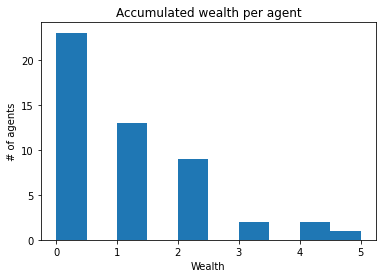

In [6]:
model = MoneyModel(50, 10, 10)

for i in range(20):
    model.step()

agent_wealth = [a.wealth for a in model.schedule.agents]

plt.xlabel('Wealth')
plt.ylabel('# of agents')
plt.title('Accumulated wealth per agent')
plt.hist(agent_wealth)
plt.show()

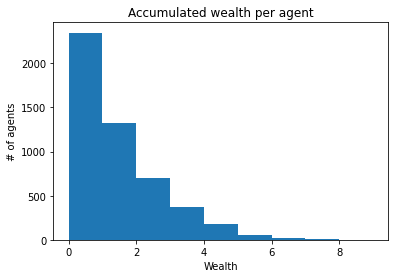

In [7]:
'''
To get a better idea of how a model behaves, we can create multiple model runs and see the distribution that emerges from all of them. We can do this with a nested for loop:

This runs 100 instantiations of the model, and runs each for 10 steps. (Notice that we set the histogram bins to be integers, since agents can only have whole numbers of wealth). This distribution looks a lot smoother. By running the model 100 times, we smooth out some of the ‘noise’ of randomness, and get to the model’s overall expected behavior.
'''

all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(50, 10, 10)
    for i in range(20):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.xlabel('Wealth')
plt.ylabel('# of agents')
plt.title('Accumulated wealth per agent')
plt.hist(all_wealth, bins=range(max(all_wealth)+1))
plt.show()

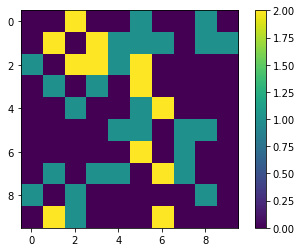

In [8]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

<AxesSubplot:title={'center':'Gini coefficient over time'}, xlabel='Time (ticks)', ylabel='Gini coefficient'>

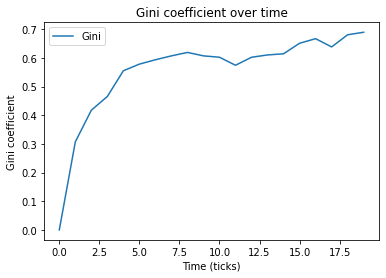

In [9]:
gini = model.datacollector.get_model_vars_dataframe()

gini.plot(xlabel = 'Time (ticks)', ylabel = 'Gini coefficient', title = 'Gini coefficient over time')


In [10]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

<AxesSubplot:>

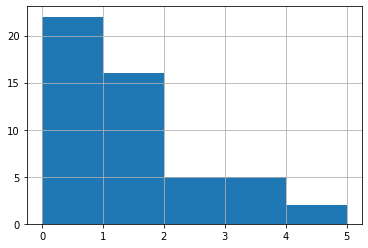

In [11]:
end_wealth = agent_wealth.xs(9, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

In [12]:
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


AssertionError: 

245it [01:02,  3.92it/s]


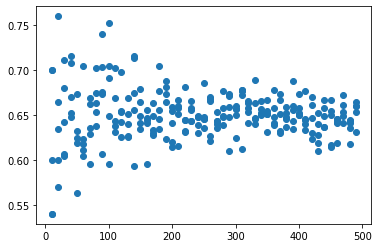

In [12]:
'''
We instantiate a BatchRunner with a model class to run, and two dictionaries: one of the fixed parameters (mapping model arguments to values) and one of varying parameters (mapping each parameter name to a sequence of values for it to take). The BatchRunner also takes an argument for how many model instantiations to create and run at each combination of parameter values, and how many steps to run each instantiation for. Finally, like the DataCollector, it takes dictionaries of model- and agent-level reporters to collect. Unlike the DataCollector, it won’t collect the data every step of the model, but only at the end of each run.

In the following example, we hold the height and width fixed, and vary the number of agents. We tell the BatchRunner to run 5 instantiations of the model with each number of agents, and to run each for 100 steps. We have it collect the final Gini coefficient value.
'''

fixed_params = {
    "width": 10,
    "height": 10
}

variable_params = {"N": range(10, 500, 10)}

# The variables parameters will be invoke along with the fixed parameters allowing for either or both to be honored.
batch_run = BatchRunner(
    MoneyModel,
    variable_params,
    fixed_params,
    iterations=5,
    max_steps=100,
    model_reporters={"Gini": compute_gini}
)

batch_run.run_all()

run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)